In [70]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import matplotlib.pyplot as plt
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
import pandas as pd
from models.mnist_conv import mnist_conv

# Fix the random seed

In [71]:
random_seed = 2
cf.seed_torch(random_seed)

# Configure the expirement

In [72]:
weights_path = '../checkpoints/mnist_conv_dense.pth'

conf_args = {#
    # data specification
    'data_file':"../../Data",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':0, 'cuda_device':0, 'pin_memory':True,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.07, 'lamda_0':0.4, 'lamda_1':0.4, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.0,
    # initialization
    'sparse_init':0.01, 'r':[1,1,1],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
    'batch_size': 1
}

conf = cf.Conf(**conf_args)

# Initiate model

In [73]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

model = mnist_conv(**model_kwargs)

# Load model weights

In [74]:
model_weights = torch.load(weights_path)

# Apply the weights
model.load_state_dict(model_weights)
model = model.to(conf.device)

# Dataset

In [75]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

# Show the model works

In [76]:
model.eval()

train.test(conf, model, test_loader)

--------------------------------------------------
Test Accuracy: 0.9072


{'acc': 0.9072, 'loss': 2987.0475267623483}

# Attack the Model

In [77]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(conf.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(conf.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)


def bim_attack(model, data, target, eps, alpha, iters):
    # Copy the original images to avoid modifying them
    adv_images = data.clone().detach()
    
    # Loop over the number of iterations
    for _ in range(iters):
        # Requires gradient
        adv_images.requires_grad = True

        # Forward pass
        outputs = model(adv_images)
        model.zero_grad()

        # Calculate loss
        loss = F.cross_entropy(outputs, target)

        # Backward pass
        loss.backward()

        # Adversarial example update
        perturbation = alpha * adv_images.grad.sign()
        adv_images = adv_images + perturbation
        perturbation = torch.clamp(adv_images - data, min=-eps, max=eps)
        adv_images = torch.clamp(data + perturbation, min=0, max=1)

    return adv_images

def get_batch(loader):
    for data, target in loader:
        return data, target
    
    
def test_bim(model, data, target, conf):
    correct = 0
    adv_examples = []
    
    for x, y in zip(data, target):
        
        x, y = data.to(conf.device), target.to(conf.device)
        output = model(x)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = x.squeeze().detach().cpu().numpy()
                adv_examples.append( (y.item(), final_pred.item(), adv_ex) )
        

def test(model, test_loader, conf, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(conf.device), target.to(conf.device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss 
        # TODO: run attack with corret loss function
        loss = F.cross_entropy(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [79]:
epsilons = [0, .005, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, test_loader, conf, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9072 / 10000 = 0.9072
Epsilon: 0.005	Test Accuracy = 6504 / 10000 = 0.6504
Epsilon: 0.05	Test Accuracy = 1045 / 10000 = 0.1045
Epsilon: 0.1	Test Accuracy = 481 / 10000 = 0.0481
Epsilon: 0.15	Test Accuracy = 413 / 10000 = 0.0413
Epsilon: 0.2	Test Accuracy = 416 / 10000 = 0.0416
Epsilon: 0.25	Test Accuracy = 449 / 10000 = 0.0449
Epsilon: 0.3	Test Accuracy = 473 / 10000 = 0.0473


In [80]:
data_dict = { 'epsilons': epsilons, 'accuracy': accuracies }
df = pd.DataFrame(data_dict)
df

,epsilons,accuracy
0,0.000,0.9072
1,0.005,0.6504
2,0.050,0.1045
3,0.100,0.0481
4,0.150,0.0413
5,0.200,0.0416
6,0.250,0.0449
7,0.300,0.0473


In [81]:
df.to_csv('../results/dense_adam_FGM_attack.csv')

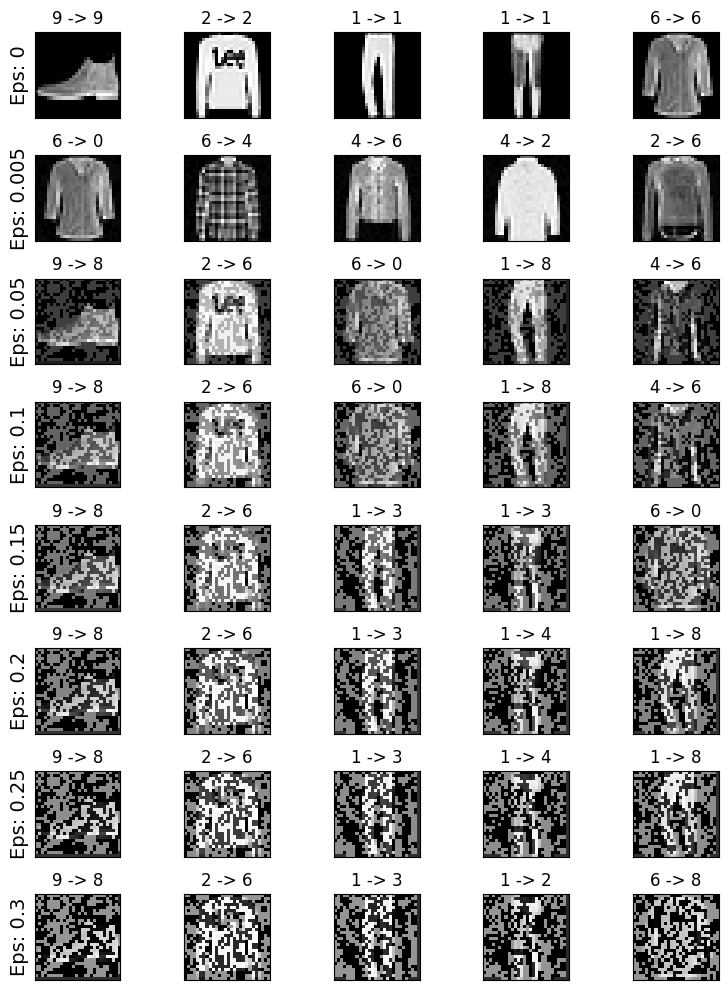

In [82]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()    

In [ ]:
epsilons = [0, .005, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

data, target = get_batch(test_loader)

for eps in epsilons:
    
    acc, ex = test(model, test_loader, conf, eps)
    accuracies.append(acc)
    examples.append(ex)